In [1]:
library(lmerTest)
library(MuMIn)
library(VIF)
library(sqldf)
library(car)
library(ggplot2)
library(sjPlot)
library(sjmisc)
library(sjlabelled)
library(ggeffects)


filename <- 'generated/num_of_review_comments.csv'

effectiveCommentsData <- read.csv(file=filename, header=TRUE, sep=",")

effectiveCommentsData$LanguageType = as.factor(effectiveCommentsData$LanguageType)

effectiveCommentsData$EffectiveComments = log(effectiveCommentsData$EffectiveComments + 1)
effectiveCommentsData$Additions = log(effectiveCommentsData$Additions + 1)
effectiveCommentsData$Deletions = log(effectiveCommentsData$Deletions + 1)
effectiveCommentsData$TotalReviewComments = log(effectiveCommentsData$TotalReviewComments + 1)
effectiveCommentsData$TotalReviewCommentThreads = log(effectiveCommentsData$TotalReviewCommentThreads + 1)
effectiveCommentsData$GeneralComments = log(effectiveCommentsData$GeneralComments + 1)
effectiveCommentsData$Commits = log(effectiveCommentsData$Commits + 1)
effectiveCommentsData$Assignees = log(effectiveCommentsData$Assignees + 1)
effectiveCommentsData$ChangedFiles = log(effectiveCommentsData$ChangedFiles + 1)
effectiveCommentsData$PrOpenedDaysAfterProjectStart = log(effectiveCommentsData$PrOpenedDaysAfterProjectStart + 1)
effectiveCommentsData$NumOfUniqueUsers = log(effectiveCommentsData$NumOfUniqueUsers + 1)
effectiveCommentsData$PRsOpened = log(effectiveCommentsData$PRsOpened + 1)
effectiveCommentsData$TotalBuilds = log(effectiveCommentsData$TotalBuilds + 1)
effectiveCommentsData$AdditionsAfterCreate = log(effectiveCommentsData$AdditionsAfterCreate + 1)
effectiveCommentsData$CommitsAfterCreate = log(effectiveCommentsData$CommitsAfterCreate + 1)
effectiveCommentsData$DeletionsAfterCreate = log(effectiveCommentsData$DeletionsAfterCreate + 1)

summary(effectiveCommentsData)

Loading required package: Matrix
Loading required package: lme4

Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step

Loading required package: gsubfn
Loading required package: proto
Warning message:
“no DISPLAY variable so Tk is not available”Loading required package: RSQLite

Attaching package: ‘car’

The following object is masked from ‘package:VIF’:

    vif



 EffectiveComments TotalReviewComments TotalReviewCommentThreads
 Min.   :0.00000   Min.   :0.0000      Min.   :0.0000           
 1st Qu.:0.00000   1st Qu.:0.0000      1st Qu.:0.0000           
 Median :0.00000   Median :0.0000      Median :0.0000           
 Mean   :0.06094   Mean   :0.3029      Mean   :0.2795           
 3rd Qu.:0.00000   3rd Qu.:0.0000      3rd Qu.:0.0000           
 Max.   :5.56068   Max.   :6.0426      Max.   :6.0039           
                                                                
 ShareReviewComments GeneralComments  GeneralCommentsDiscussingBuild
 Min.   :  0.00      Min.   :0.0000   Min.   :0                     
 1st Qu.:  0.00      1st Qu.:0.0000   1st Qu.:0                     
 Median :  0.00      Median :0.6931   Median :0                     
 Mean   : 10.49      Mean   :0.8910   Mean   :0                     
 3rd Qu.:  0.00      3rd Qu.:1.3863   3rd Qu.:0                     
 Max.   :100.00      Max.   :6.9431   Max.   :0                   

In [2]:
hasEffectiveComments <- sqldf("select *
                      from 'effectiveCommentsData' 
                      where EffectiveComments > 0")

print(nrow(hasEffectiveComments))

summary(hasEffectiveComments)

no_linter_static = nrow(subset(hasEffectiveComments, Linter == 'False' & LanguageType == 'static'))
linter_static = nrow(subset(hasEffectiveComments, Linter == 'True' & LanguageType == 'static'))

no_linter_dynamic = nrow(subset(hasEffectiveComments, Linter == 'False' & LanguageType == 'dynamic'))
linter_dynamic = nrow(subset(hasEffectiveComments, Linter == 'True' & LanguageType == 'dynamic'))


print(no_linter_static)
print(linter_static)

print(no_linter_dynamic)
print(linter_dynamic)

[1] 15296


 EffectiveComments TotalReviewComments TotalReviewCommentThreads
 Min.   :0.6931    Min.   :0.6931      Min.   :0.6931           
 1st Qu.:0.6931    1st Qu.:1.0986      1st Qu.:1.0986           
 Median :1.0986    Median :1.7918      Median :1.6094           
 Mean   :1.3019    Mean   :1.9311      Mean   :1.7907           
 3rd Qu.:1.6094    3rd Qu.:2.5649      3rd Qu.:2.3979           
 Max.   :5.5607    Max.   :5.8833      Max.   :5.8833           
                                                                
 ShareReviewComments GeneralComments GeneralCommentsDiscussingBuild
 Min.   :  1.19      Min.   :0.000   Min.   :0                     
 1st Qu.: 35.71      1st Qu.:1.099   1st Qu.:0                     
 Median : 58.82      Median :1.609   Median :0                     
 Mean   : 57.85      Mean   :1.644   Mean   :0                     
 3rd Qu.: 80.00      3rd Qu.:2.303   3rd Qu.:0                     
 Max.   :100.00      Max.   :6.136   Max.   :0                     
    

[1] 1430
[1] 4194
[1] 3199
[1] 4068


# Hurdle

First we make a hurdle model to determine whether we can detect zero pull requests vs non zero pull requests. We pick an equal amount of pull requests with zero and non zero effective comments and then build a linear regression. 

In [3]:
zerosdf <- sqldf('select * from "effectiveCommentsData" where EffectiveComments = 0 and LanguageType != "unk"')

sampledZerosdf <- zerosdf[sample(nrow(zerosdf), nrow(sqldf('select * from hasEffectiveComments where LanguageType != "unk"'))),]

combined <- rbind(sampledZerosdf, sqldf('select * from hasEffectiveComments where LanguageType != "unk"'))

baseHurdleModel = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Linter +
            Coverage +
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            #CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            LanguageType +
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(baseHurdleModel)
r.squaredGLMM(baseHurdleModel)
vif(baseHurdleModel)
anova(baseHurdleModel)


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Linter + Coverage + Assignees + ChangedFiles + 
    NumOfUniqueUsers + PRsOpened + TotalBuilds + NewContributor + 
    PrOpenedDaysAfterProjectStart + FromOutsider + GeneralComments + 
    LanguageType + IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.2472  -0.5555  -0.0138   0.6697   2.7618  

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -5.483604   0.179602 -30.532  < 2e-16 ***
Additions                      0.186108   0.014030  13.265  < 2e-16 ***
Deletions                     -0.105140   0.013741  -7.651 1.99e-14 ***
IsMergedTrue                   0.782308   0.042025  18.615  < 2e-16 ***
Commits                        1.274346   0.030881  41.267  < 2e-16 ***
LinterTrue                     0.270046   0.036485   7.402 1.35e-13 ***
CoverageTrue       

R2m       R2c 
0.6426352 0.6426352

Additions                     Deletions 
                     3.346694                      2.660884 
                     IsMerged                       Commits 
                     1.149611                      1.412908 
                       Linter                      Coverage 
                     1.047134                      1.097286 
                    Assignees                  ChangedFiles 
                     1.035990                      3.877712 
             NumOfUniqueUsers                     PRsOpened 
                     2.199960                      2.996792 
                  TotalBuilds                NewContributor 
                     2.920982                      1.752893 
PrOpenedDaysAfterProjectStart                  FromOutsider 
                     1.813698                      1.937100 
              GeneralComments                  LanguageType 
                     2.250030                      1.193228 
                      IsAfter 
                     3.659723

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,25781,35741.44
Additions,1,2788.702785,25780,32952.74
Deletions,1,144.928867,25779,32807.81
IsMerged,1,27.036408,25778,32780.77
Commits,1,5289.063569,25777,27491.71
Linter,1,109.040738,25776,27382.67
Coverage,1,9.798153,25775,27372.87
Assignees,1,169.419297,25774,27203.45
ChangedFiles,1,115.348490,25773,27088.10
NumOfUniqueUsers,1,5347.174834,25772,21740.93


# Interaction between LanguageType and Travis adoption


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Linter + Coverage + Assignees + ChangedFiles + 
    NumOfUniqueUsers + PRsOpened + TotalBuilds + NewContributor + 
    PrOpenedDaysAfterProjectStart + FromOutsider + GeneralComments + 
    LanguageType * IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.2460  -0.5557  -0.0138   0.6697   2.7629  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    -5.485468   0.179899 -30.492  < 2e-16 ***
Additions                       0.186109   0.014030  13.265  < 2e-16 ***
Deletions                      -0.105124   0.013741  -7.650 2.01e-14 ***
IsMergedTrue                    0.782510   0.042041  18.613  < 2e-16 ***
Commits                         1.274384   0.030881  41.268  < 2e-16 ***
LinterTrue                      0.269989   0.036487   7.400 1.37e-13 ***
CoverageTrue

R2m       R2c 
0.6426355 0.6426355

Additions                     Deletions 
                     3.346698                      2.660961 
                     IsMerged                       Commits 
                     1.150447                      1.412985 
                       Linter                      Coverage 
                     1.047215                      1.097714 
                    Assignees                  ChangedFiles 
                     1.036140                      3.877823 
             NumOfUniqueUsers                     PRsOpened 
                     2.199947                      2.997919 
                  TotalBuilds                NewContributor 
                     2.926117                      1.753052 
PrOpenedDaysAfterProjectStart                  FromOutsider 
                     1.817889                      1.937302 
              GeneralComments                  LanguageType 
                     2.250001                      2.359057 
                      IsAfter          LanguageType:IsAfter 
                     4.672030                      2.940268

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,25781,35741.44
Additions,1,2.788703e+03,25780,32952.74
Deletions,1,1.449289e+02,25779,32807.81
IsMerged,1,2.703641e+01,25778,32780.77
Commits,1,5.289064e+03,25777,27491.71
Linter,1,1.090407e+02,25776,27382.67
Coverage,1,9.798153e+00,25775,27372.87
Assignees,1,1.694193e+02,25774,27203.45
ChangedFiles,1,1.153485e+02,25773,27088.10
NumOfUniqueUsers,1,5.347175e+03,25772,21740.93


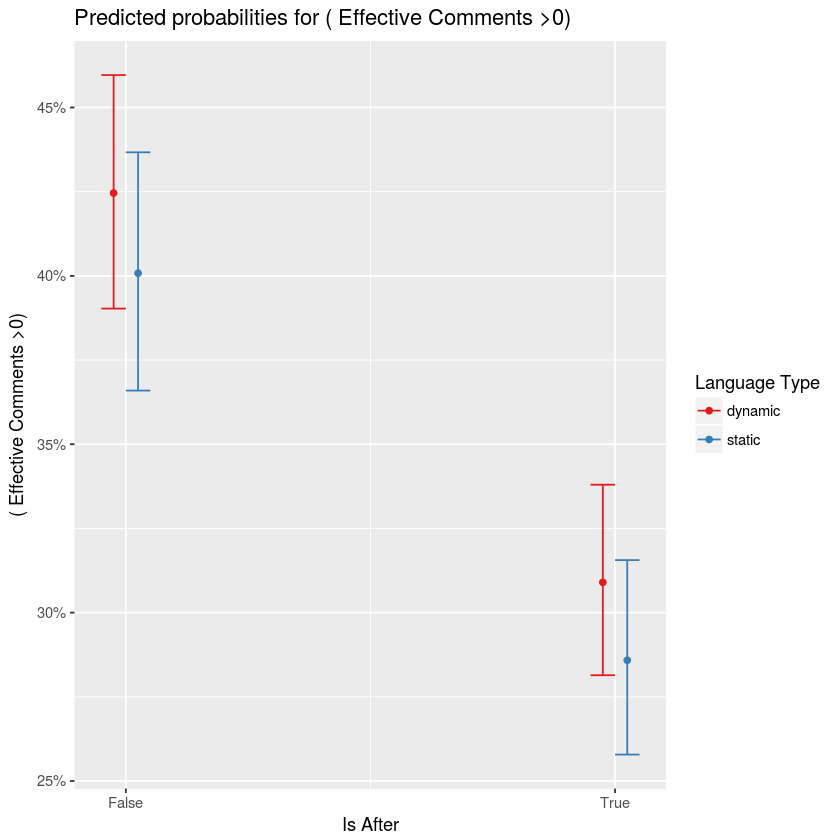

In [4]:
baseHurdleModelInteraction = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Linter +
            Coverage +
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            LanguageType *
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(baseHurdleModelInteraction)
r.squaredGLMM(baseHurdleModelInteraction)
vif(baseHurdleModelInteraction)
anova(baseHurdleModelInteraction)

plot_model(baseHurdleModelInteraction, type="pred", terms=c('IsAfter', 'LanguageType'))

# Interaction between Coverage usage and Travis adoption


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Linter + Assignees + ChangedFiles + 
    NumOfUniqueUsers + PRsOpened + TotalBuilds + NewContributor + 
    PrOpenedDaysAfterProjectStart + FromOutsider + GeneralComments + 
    LanguageType + Coverage * IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.2440  -0.5560  -0.0139   0.6691   2.7579  

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -5.469356   0.181023 -30.214  < 2e-16 ***
Additions                      0.186238   0.014032  13.272  < 2e-16 ***
Deletions                     -0.105186   0.013742  -7.654 1.95e-14 ***
IsMergedTrue                   0.781260   0.042058  18.576  < 2e-16 ***
Commits                        1.275095   0.030906  41.258  < 2e-16 ***
LinterTrue                     0.269943   0.036485   7.399 1.37e-13 ***
Assignees          

R2m       R2c 
0.6426225 0.6426225

Additions                     Deletions 
                     3.347615                      2.661264 
                     IsMerged                       Commits 
                     1.151332                      1.415122 
                       Linter                     Assignees 
                     1.047095                      1.036469 
                 ChangedFiles              NumOfUniqueUsers 
                     3.877619                      2.201324 
                    PRsOpened                   TotalBuilds 
                     3.003468                      2.929057 
               NewContributor PrOpenedDaysAfterProjectStart 
                     1.754011                      1.814186 
                 FromOutsider               GeneralComments 
                     1.937119                      2.250556 
                 LanguageType                      Coverage 
                     1.193227                      2.302154 
                      IsAfter              Coverage:IsAfter 
                     4.239423                      3.041947

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,25781,35741.44
Additions,1,2788.7027850,25780,32952.74
Deletions,1,144.9288671,25779,32807.81
IsMerged,1,27.0364080,25778,32780.77
Commits,1,5289.0635691,25777,27491.71
Linter,1,109.0407376,25776,27382.67
Assignees,1,175.7415706,25775,27206.93
ChangedFiles,1,115.7908411,25774,27091.14
NumOfUniqueUsers,1,5340.9188146,25773,21750.22
PRsOpened,1,6.3001602,25772,21743.92


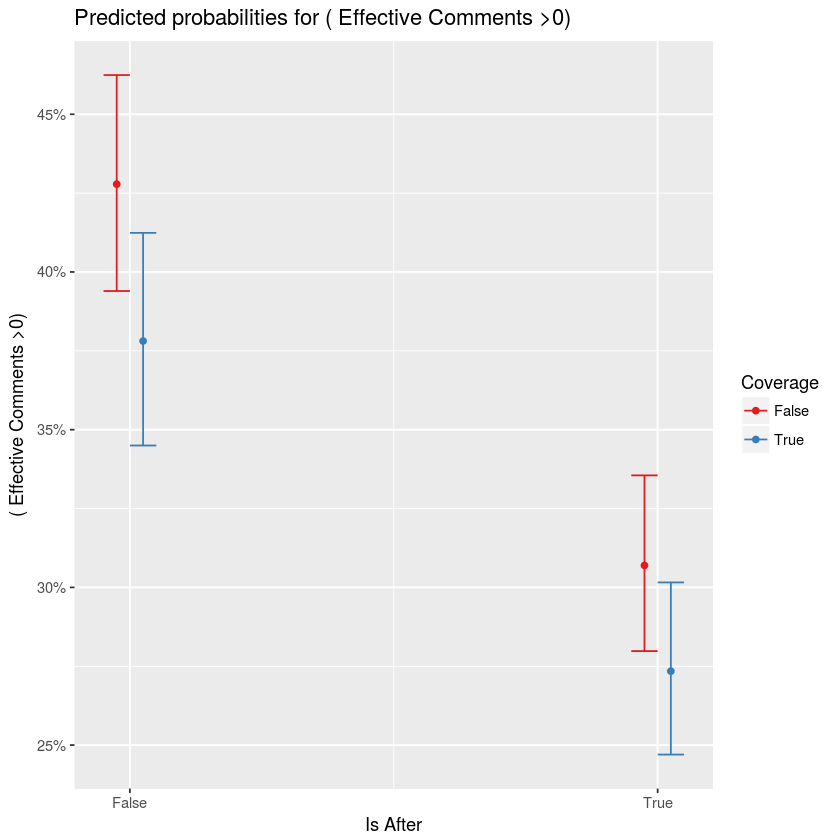

In [5]:
hurdleModelInteractionCoverage = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Linter +
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            LanguageType +
                                         Coverage*
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(hurdleModelInteractionCoverage)
r.squaredGLMM(hurdleModelInteractionCoverage)
vif(hurdleModelInteractionCoverage)
anova(hurdleModelInteractionCoverage)

plot_model(hurdleModelInteractionCoverage, type="pred", terms=c('IsAfter', 'Coverage'))

# Interaction Linter with Travis Introduction


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Coverage + Assignees + ChangedFiles + 
    NumOfUniqueUsers + PRsOpened + TotalBuilds + NewContributor + 
    PrOpenedDaysAfterProjectStart + FromOutsider + GeneralComments + 
    LanguageType + Linter * IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.2436  -0.5568  -0.0136   0.6692   2.7672  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -5.5153822  0.1823984 -30.238  < 2e-16 ***
Additions                      0.1862224  0.0140327  13.271  < 2e-16 ***
Deletions                     -0.1052929  0.0137438  -7.661 1.84e-14 ***
IsMergedTrue                   0.7813804  0.0420326  18.590  < 2e-16 ***
Commits                        1.2747742  0.0308862  41.273  < 2e-16 ***
CoverageTrue                  -0.1829914  0.0363883  -5.029 4.93e-07 ***
Assignees   

R2m       R2c 
0.6426791 0.6426791

Additions                     Deletions 
                     3.347511                      2.661371 
                     IsMerged                       Commits 
                     1.150173                      1.413493 
                     Coverage                     Assignees 
                     1.096969                      1.036231 
                 ChangedFiles              NumOfUniqueUsers 
                     3.878251                      2.200792 
                    PRsOpened                   TotalBuilds 
                     3.000156                      2.919249 
               NewContributor PrOpenedDaysAfterProjectStart 
                     1.754088                      1.815254 
                 FromOutsider               GeneralComments 
                     1.939430                      2.252571 
                 LanguageType                        Linter 
                     1.193178                      2.198853 
                      IsAfter                Linter:IsAfter 
                     5.342662                      3.868275

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,25781,35741.44
Additions,1,2788.702785,25780,32952.74
Deletions,1,144.928867,25779,32807.81
IsMerged,1,27.036408,25778,32780.77
Commits,1,5289.063569,25777,27491.71
Coverage,1,8.655441,25776,27483.05
Assignees,1,156.859882,25775,27326.19
ChangedFiles,1,115.859177,25774,27210.34
NumOfUniqueUsers,1,5422.788435,25773,21787.55
PRsOpened,1,7.756412,25772,21779.79


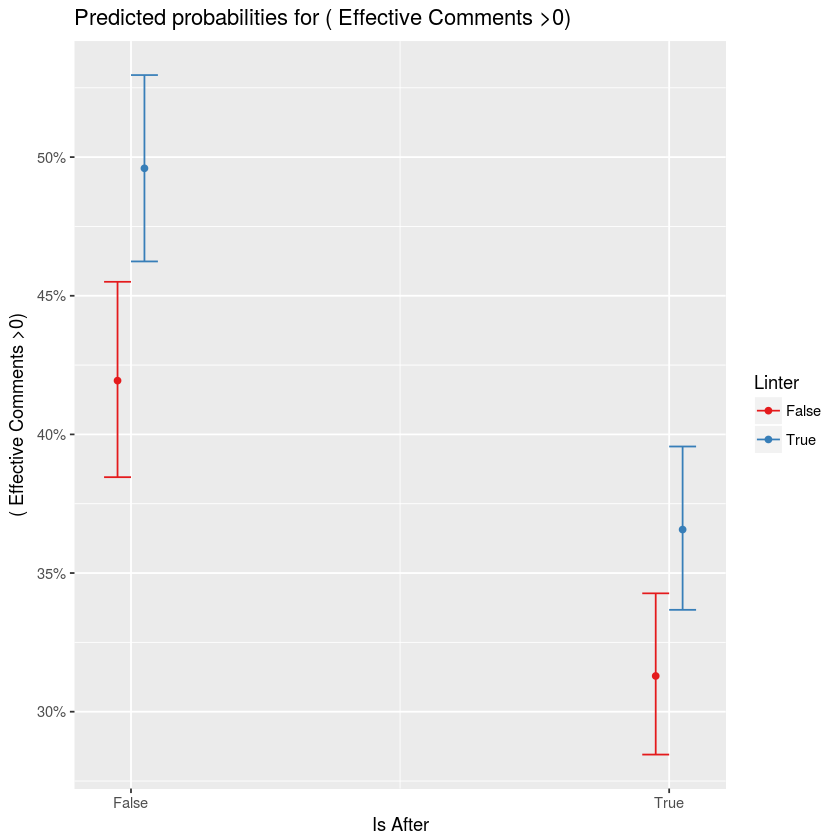

In [6]:
hurdleModelInteractionLinter = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Coverage +
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            LanguageType +
                                         Linter*
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(hurdleModelInteractionLinter)
r.squaredGLMM(hurdleModelInteractionLinter)
vif(hurdleModelInteractionLinter)
anova(hurdleModelInteractionLinter)

plot_model(hurdleModelInteractionLinter, type="pred", terms=c('IsAfter', 'Linter'))

# Interaction between coverage, linter and Travis introduction


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Assignees + ChangedFiles + NumOfUniqueUsers + 
    PRsOpened + TotalBuilds + NewContributor + PrOpenedDaysAfterProjectStart + 
    FromOutsider + GeneralComments + LanguageType + Coverage * 
    Linter * IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.2619  -0.5606  -0.0133   0.6647   2.7790  

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         -5.576411   0.185738 -30.023  < 2e-16 ***
Additions                            0.187751   0.014040  13.372  < 2e-16 ***
Deletions                           -0.104517   0.013758  -7.597 3.04e-14 ***
IsMergedTrue                         0.781902   0.042113  18.567  < 2e-16 ***
Commits                              1.275283   0.030963  41.187  < 2e-16 ***
Assignees                            0.901411   0.08344

R2m       R2c 
0.6444714 0.6444714

Additions                     Deletions 
                     3.348764                      2.663723 
                     IsMerged                       Commits 
                     1.152097                      1.417739 
                    Assignees                  ChangedFiles 
                     1.040577                      3.882679 
             NumOfUniqueUsers                     PRsOpened 
                     2.202547                      3.005961 
                  TotalBuilds                NewContributor 
                     2.934959                      1.755613 
PrOpenedDaysAfterProjectStart                  FromOutsider 
                     1.820085                      1.961602 
              GeneralComments                  LanguageType 
                     2.253362                      1.246529 
                     Coverage                        Linter 
                     6.165762                      3.741110 
                      IsAfter               Coverage:Linter 
                     7.189510                      7.773132 
             Coverage:IsAfter                Linter:IsAfter 
                     8.146283                      6.829106 
      Coverage:Linter:IsAfter 
                     9.238165

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,25781,35741.44
Additions,1,2.788703e+03,25780,32952.74
Deletions,1,1.449289e+02,25779,32807.81
IsMerged,1,2.703641e+01,25778,32780.77
Commits,1,5.289064e+03,25777,27491.71
Assignees,1,1.625801e+02,25776,27329.13
ChangedFiles,1,1.162816e+02,25775,27212.85
NumOfUniqueUsers,1,5.415852e+03,25774,21797.00
PRsOpened,1,8.722167e+00,25773,21788.27
TotalBuilds,1,2.837951e+02,25772,21504.48


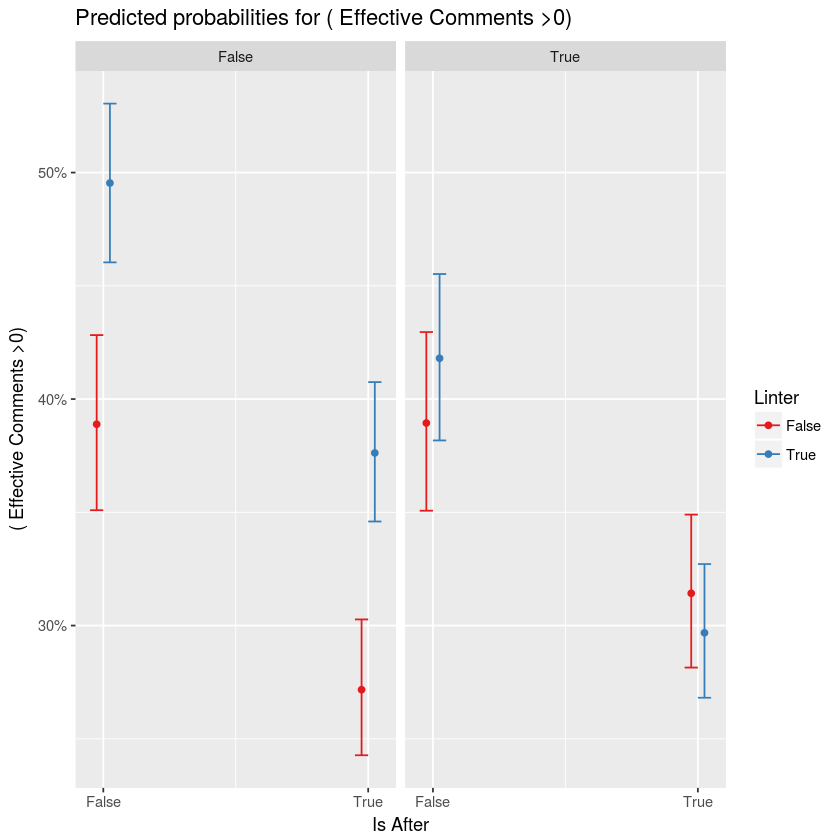

In [7]:
hurdleModelInteractionCoverageLinter = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            LanguageType +
                                           Coverage*
                                         Linter*
            IsAfter ,
          data=combined,
                 family = 'binomial')
summary(hurdleModelInteractionCoverageLinter)
r.squaredGLMM(hurdleModelInteractionCoverageLinter)
vif(hurdleModelInteractionCoverageLinter)
anova(hurdleModelInteractionCoverageLinter)

plot_model(hurdleModelInteractionCoverageLinter, type="pred", terms=c('IsAfter', 'Linter', 'Coverage'))

# Interaction between language type, linter and travis


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Assignees + ChangedFiles + NumOfUniqueUsers + 
    PRsOpened + TotalBuilds + NewContributor + PrOpenedDaysAfterProjectStart + 
    FromOutsider + GeneralComments + Coverage + LanguageType * 
    Linter * IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.2568  -0.5562  -0.0136   0.6692   2.7538  

Coefficients:
                                           Estimate Std. Error z value Pr(>|z|)
(Intercept)                               -5.490294   0.185374 -29.617  < 2e-16
Additions                                  0.185634   0.014043  13.219  < 2e-16
Deletions                                 -0.104834   0.013751  -7.624 2.46e-14
IsMergedTrue                               0.778594   0.042071  18.507  < 2e-16
Commits                                    1.274839   0.030896  41.263  < 2e-16
Assignees                                  

R2m       R2c 
0.6430565 0.6430565

Additions                     Deletions 
                     3.352451                      2.663579 
                     IsMerged                       Commits 
                     1.152294                      1.414066 
                    Assignees                  ChangedFiles 
                     1.039598                      3.882221 
             NumOfUniqueUsers                     PRsOpened 
                     2.200319                      3.005417 
                  TotalBuilds                NewContributor 
                     2.929077                      1.754611 
PrOpenedDaysAfterProjectStart                  FromOutsider 
                     1.825224                      1.949071 
              GeneralComments                      Coverage 
                     2.252316                      1.161162 
                 LanguageType                        Linter 
                     6.903377                      3.721088 
                      IsAfter           LanguageType:Linter 
                     6.802038                      8.882561 
         LanguageType:IsAfter                Linter:IsAfter 
                     8.750677                      6.589948 
  LanguageType:Linter:IsAfter 
                    10.410682

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,25781,35741.44
Additions,1,2.788703e+03,25780,32952.74
Deletions,1,1.449289e+02,25779,32807.81
IsMerged,1,2.703641e+01,25778,32780.77
Commits,1,5.289064e+03,25777,27491.71
Assignees,1,1.625801e+02,25776,27329.13
ChangedFiles,1,1.162816e+02,25775,27212.85
NumOfUniqueUsers,1,5.415852e+03,25774,21797.00
PRsOpened,1,8.722167e+00,25773,21788.27
TotalBuilds,1,2.837951e+02,25772,21504.48


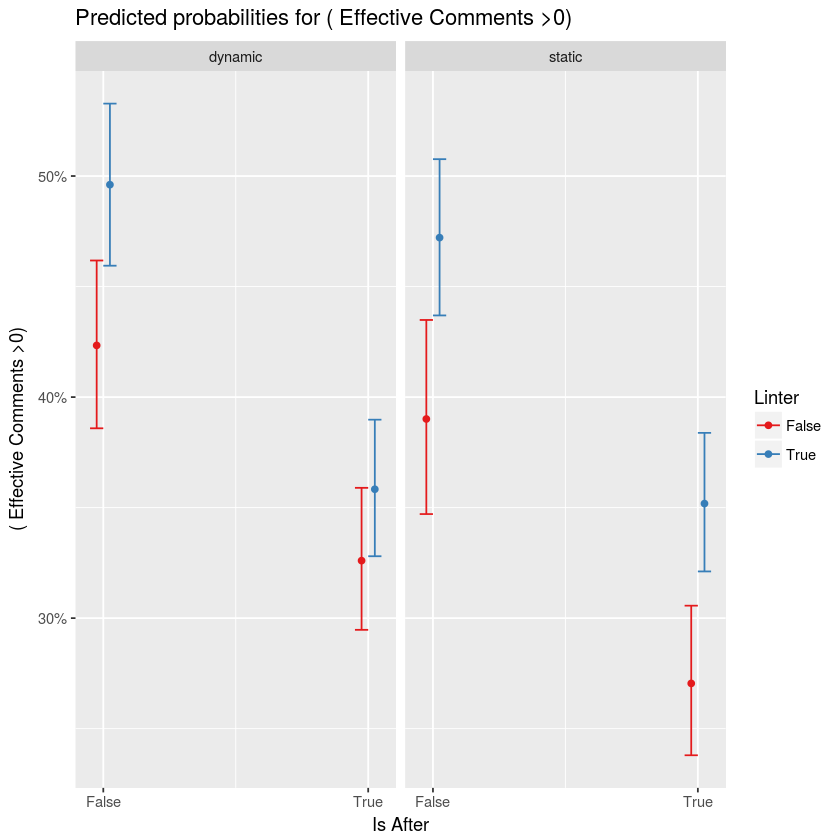

In [8]:
hurdleModelInteractionLanguageLinter = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            Coverage +
            LanguageType *
            Linter*
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(hurdleModelInteractionLanguageLinter)
r.squaredGLMM(hurdleModelInteractionLanguageLinter)
vif(hurdleModelInteractionLanguageLinter)
anova(hurdleModelInteractionLanguageLinter)

plot_model(hurdleModelInteractionLanguageLinter, type="pred", terms=c('IsAfter', 'Linter', 'LanguageType'))

# Interaction between langauge type, coverage and Travis


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Assignees + ChangedFiles + NumOfUniqueUsers + 
    PRsOpened + TotalBuilds + NewContributor + PrOpenedDaysAfterProjectStart + 
    FromOutsider + GeneralComments + Linter + LanguageType * 
    Coverage * IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.2416  -0.5562  -0.0139   0.6703   2.7509  

Coefficients:
                                             Estimate Std. Error z value
(Intercept)                                 -5.488219   0.182439 -30.083
Additions                                    0.186634   0.014040  13.293
Deletions                                   -0.105132   0.013748  -7.647
IsMergedTrue                                 0.780260   0.042103  18.532
Commits                                      1.274459   0.030931  41.203
Assignees                                    0.881442   0.083440  10.564
ChangedFiles

R2m       R2c 
0.6426359 0.6426359

Additions                     Deletions 
                     3.350897                      2.663502 
                     IsMerged                       Commits 
                     1.153689                      1.417617 
                    Assignees                  ChangedFiles 
                     1.039769                      3.884739 
             NumOfUniqueUsers                     PRsOpened 
                     2.201970                      3.006893 
                  TotalBuilds                NewContributor 
                     2.935576                      1.754635 
PrOpenedDaysAfterProjectStart                  FromOutsider 
                     1.825383                      1.938849 
              GeneralComments                        Linter 
                     2.252562                      1.102548 
                 LanguageType                      Coverage 
                     3.857836                      3.959225 
                      IsAfter         LanguageType:Coverage 
                     6.776356                      4.707344 
         LanguageType:IsAfter              Coverage:IsAfter 
                     5.193912                      5.387078 
LanguageType:Coverage:IsAfter 
                     5.087051

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,25781,35741.44
Additions,1,2.788703e+03,25780,32952.74
Deletions,1,1.449289e+02,25779,32807.81
IsMerged,1,2.703641e+01,25778,32780.77
Commits,1,5.289064e+03,25777,27491.71
Assignees,1,1.625801e+02,25776,27329.13
ChangedFiles,1,1.162816e+02,25775,27212.85
NumOfUniqueUsers,1,5.415852e+03,25774,21797.00
PRsOpened,1,8.722167e+00,25773,21788.27
TotalBuilds,1,2.837951e+02,25772,21504.48


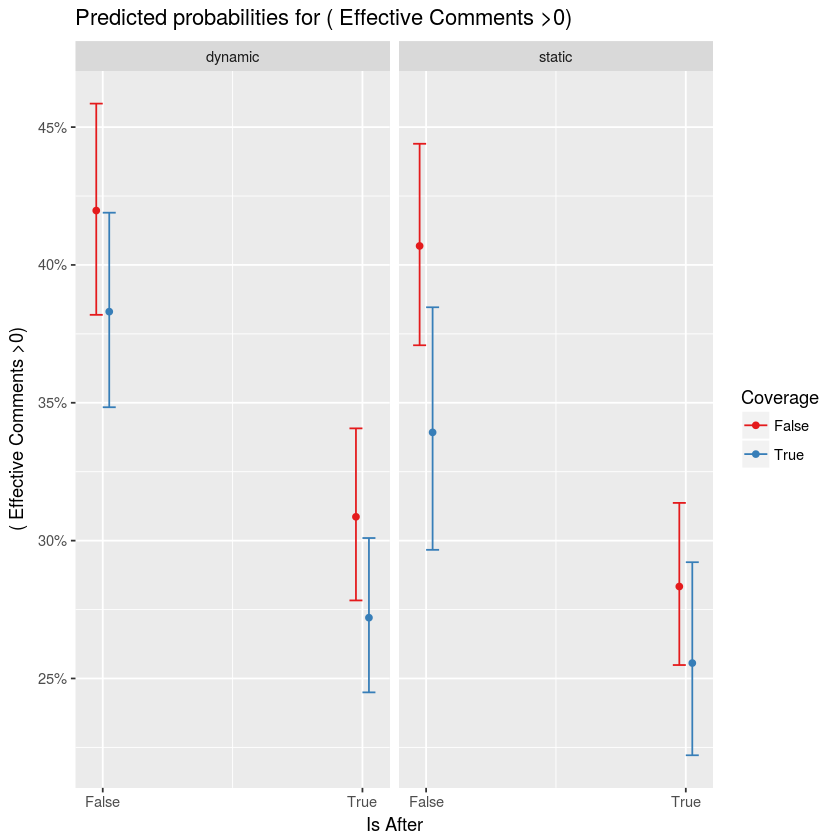

In [9]:
hurdleModelInteractionLanguageCoverage = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            Linter +
            LanguageType *
            Coverage*
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(hurdleModelInteractionLanguageCoverage)
r.squaredGLMM(hurdleModelInteractionLanguageCoverage)
vif(hurdleModelInteractionLanguageCoverage)
anova(hurdleModelInteractionLanguageCoverage)

plot_model(hurdleModelInteractionLanguageCoverage, type="pred", terms=c('IsAfter', 'Coverage', 'LanguageType'))

# Interaction between language type, coverage and linter (no travis!)


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Assignees + ChangedFiles + NumOfUniqueUsers + 
    PRsOpened + TotalBuilds + NewContributor + PrOpenedDaysAfterProjectStart + 
    FromOutsider + GeneralComments + LanguageType * Linter * 
    Coverage + IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.2434  -0.5594  -0.0134   0.6657   2.7524  

Coefficients:
                                           Estimate Std. Error z value Pr(>|z|)
(Intercept)                                -5.64500    0.18474 -30.557  < 2e-16
Additions                                   0.18893    0.01405  13.445  < 2e-16
Deletions                                  -0.10594    0.01377  -7.696 1.41e-14
IsMergedTrue                                0.78659    0.04210  18.685  < 2e-16
Commits                                     1.27568    0.03098  41.172  < 2e-16
Assignees                                  

R2m       R2c 
0.6444387 0.6444387

Additions                     Deletions 
                     3.352694                      2.666627 
                     IsMerged                       Commits 
                     1.150837                      1.417662 
                    Assignees                  ChangedFiles 
                     1.046760                      3.886208 
             NumOfUniqueUsers                     PRsOpened 
                     2.201384                      3.008719 
                  TotalBuilds                NewContributor 
                     2.931319                      1.753251 
PrOpenedDaysAfterProjectStart                  FromOutsider 
                     1.821129                      1.961822 
              GeneralComments                  LanguageType 
                     2.252601                      4.946001 
                       Linter                      Coverage 
                     4.061445                      4.357039 
                      IsAfter           LanguageType:Linter 
                     3.670518                      6.765907 
        LanguageType:Coverage               Linter:Coverage 
                    20.709641                      6.146146 
 LanguageType:Linter:Coverage 
                    22.678790

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,25781,35741.44
Additions,1,2.788703e+03,25780,32952.74
Deletions,1,1.449289e+02,25779,32807.81
IsMerged,1,2.703641e+01,25778,32780.77
Commits,1,5.289064e+03,25777,27491.71
Assignees,1,1.625801e+02,25776,27329.13
ChangedFiles,1,1.162816e+02,25775,27212.85
NumOfUniqueUsers,1,5.415852e+03,25774,21797.00
PRsOpened,1,8.722167e+00,25773,21788.27
TotalBuilds,1,2.837951e+02,25772,21504.48


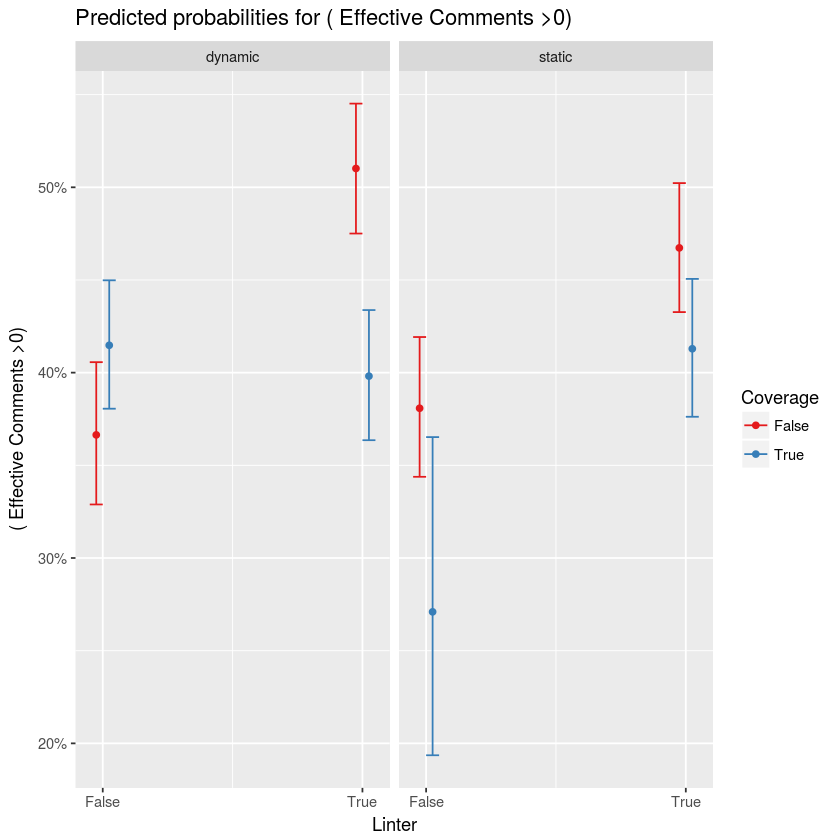

In [10]:
hurdleModelInteractionLanguageCoverageLinter = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            LanguageType *
            Linter*
            Coverage+
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(hurdleModelInteractionLanguageCoverageLinter)
r.squaredGLMM(hurdleModelInteractionLanguageCoverageLinter)
vif(hurdleModelInteractionLanguageCoverageLinter)
anova(hurdleModelInteractionLanguageCoverageLinter)

plot_model(hurdleModelInteractionLanguageCoverageLinter, type="pred", terms=c('Linter', 'Coverage', 'LanguageType'))

# Linear models!

In [11]:
executeLmOnData <- function(formula, data) {
    model = lm(formula ,
          data= data)
    print(summary(model))
    #r.squaredGLMM(model)
    print(vif(model))
    print(anova(model))
    
    return(model)
}

In [12]:
baseModel <- executeLmOnData(
            EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            Linter +
            Coverage +
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            IsAfter ,
        hasEffectiveComments)


Call:
lm(formula = formula, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.8153 -0.4406 -0.1289  0.3293  3.6961 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.8854533  0.0561769  15.762  < 2e-16 ***
Additions                      0.0955982  0.0040090  23.846  < 2e-16 ***
Deletions                     -0.0486340  0.0037058 -13.124  < 2e-16 ***
IsMergedTrue                  -0.0030261  0.0133782  -0.226 0.821053    
Assignees                      0.0421617  0.0216774   1.945 0.051798 .  
LinterTrue                     0.0125244  0.0106605   1.175 0.240079    
CoverageTrue                  -0.0008034  0.0110076  -0.073 0.941821    
ChangedFiles                   0.0006898  0.0090675   0.076 0.939365    
NumOfUniqueUsers               0.2804753  0.0192159  14.596  < 2e-16 ***
PRsOpened                     -0.0188472  0.0043960  -4.287 1.82e-05 ***
TotalBuilds                    0.1717188  0.00

# Language type

This cell introduces language type (dynamic / static / unk) to the linear model. This shows a very small increase in the accuracy of the model.

Commits, additions and deletions after create are not included because of high vif scores. 

In [13]:
ltypeModel <- executeLmOnData(
            EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            Linter +
            Coverage +
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            LanguageType +
                IsAfter ,
        sqldf("
            select * from hasEffectiveComments
            where LanguageType != 'unk'
")
        )


Call:
lm(formula = formula, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.8331 -0.4471 -0.1246  0.3316  3.6759 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.843076   0.061478  13.713  < 2e-16 ***
Additions                      0.096703   0.004483  21.569  < 2e-16 ***
Deletions                     -0.049414   0.004082 -12.106  < 2e-16 ***
IsMergedTrue                  -0.009980   0.014558  -0.686 0.493021    
Assignees                      0.040742   0.024141   1.688 0.091494 .  
LinterTrue                     0.015953   0.012367   1.290 0.197079    
CoverageTrue                  -0.015549   0.012271  -1.267 0.205122    
ChangedFiles                   0.010136   0.010113   1.002 0.316228    
NumOfUniqueUsers               0.293878   0.021418  13.721  < 2e-16 ***
PRsOpened                     -0.015735   0.004929  -3.192 0.001414 ** 
TotalBuilds                    0.177023   0.009843  17.98

## Language type as interaction effect

Adding in language type as in interaction effect with IsAfter does not appear to have any effect on the accuracy of the model. 


Call:
lm(formula = formula, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.8544 -0.4468 -0.1251  0.3332  3.6972 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     0.837319   0.061494  13.616  < 2e-16 ***
Additions                       0.096824   0.004482  21.602  < 2e-16 ***
LinterTrue                      0.015998   0.012364   1.294 0.195708    
CoverageTrue                   -0.014750   0.012270  -1.202 0.229368    
Deletions                      -0.049444   0.004081 -12.116  < 2e-16 ***
IsMergedTrue                   -0.008445   0.014564  -0.580 0.562040    
Assignees                       0.040302   0.024134   1.670 0.094960 .  
ChangedFiles                    0.010344   0.010110   1.023 0.306258    
NumOfUniqueUsers                0.293701   0.021412  13.716  < 2e-16 ***
PRsOpened                      -0.016462   0.004934  -3.336 0.000851 ***
TotalBuilds                     0.176218   0.0

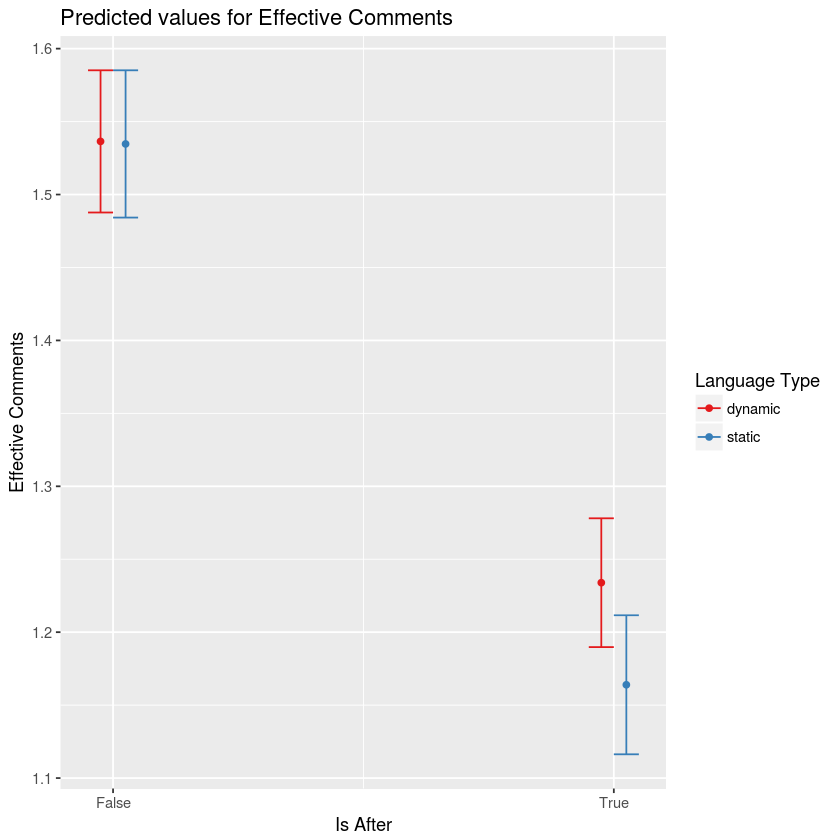

In [14]:
ltypeInteraction <- executeLmOnData(
            EffectiveComments ~ 
            Additions + 
            Linter +
            Coverage +
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            LanguageType *
            IsAfter ,
        sqldf("
            select * from hasEffectiveComments
            where LanguageType != 'unk'
"))

plot_model(ltypeInteraction, type="pred", terms=c('IsAfter', 'LanguageType'))

# Finding projects that experience more effect from Travis

In [15]:
projectNames = sqldf('Select distinct(ProjectName) from hasEffectiveComments')$ProjectName

projectResults = data.frame(ProjectName=character(),
                            PRs = integer(),
                           PValue=double(),
                            R2=double(),
                           Coefficient=double(),
                           PercentageExplained=double(),
                            ModelType=character(),
                           stringsAsFactors=FALSE)

for(project in projectNames) {
        formula <- EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
                IsAfter
    
    data <- sqldf(sprintf("select * from hasEffectiveComments
                    where ProjectName ='%s'", project))
    
    data$IsMerged <- factor(data$IsMerged)
    data$NewContributor <- factor(data$NewContributor)
    data$FromOutsider <- factor(data$FromOutsider)
    data$IsAfter <- factor(data$IsAfter)
    
    #Skip running an analysis if there is not enough data
    if(nlevels(data$IsMerged) > 1 &
      nlevels(data$NewContributor) > 1 &
      nlevels(data$FromOutsider) > 1 &
      nlevels(data$IsAfter) > 1)
    {    
        model_per_project <- lm(formula, data=data)
        
        pVals <- summary(model_per_project)$coefficients[,"Pr(>|t|)"]
        
        pOfIsAfter <- NA
        percentageExplained <- NA
        
        if("IsAfterTrue" %in% names(pVals)) {
            pOfIsAfter <- pVals[["IsAfterTrue"]]
        
            av <- anova(model_per_project)
            
            isAfterSum <- av$"Sum Sq"[length(av$"Sum Sq")]
        
            total <- 0
            for(sQrs in av$"Sum Sq") {
                total = sQrs + total
            }
        
            percentageExplained = isAfterSum / total * 100
        }
        
        
        coefs <- coef(model_per_project)
        
        isAfterCoef <- coefs[["IsAfterTrue"]]
        
        row <- data.frame(
                        ProjectName=project,
                            PRs = nrow(data),
                           PValue=pOfIsAfter,
                            R2=summary(model_per_project)$r.squared,
                           Coefficient=isAfterCoef,
                           PercentageExplained=percentageExplained,
                            ModelType = "Non-Hurdle",
                           stringsAsFactors=FALSE)
        
        projectResults <- rbind(projectResults, row)
    }
}

Warning message in anova.lm(model_per_project):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(model_per_project):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(model_per_project):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(model_per_project):
“ANOVA F-tests on an essentially perfect fit are unreliable”

In [16]:
projectNames = sqldf('Select distinct(ProjectName) from hasEffectiveComments')$ProjectName

for(project in projectNames) {
        formula <- (EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
                IsAfter
    
    zerosdf_project <- sqldf(sprintf('select * from "effectiveCommentsData" where EffectiveComments = 0 and ProjectName="%s"',project))

    sampledZerosdf_project <- zerosdf_project[sample(nrow(zerosdf_project), nrow(sqldf(sprintf('select * from hasEffectiveComments where ProjectName="%s"', project)))),]

    combined_project <- rbind(sampledZerosdf_project, sqldf(sprintf("select * from hasEffectiveComments
                    where ProjectName ='%s'", project)))

    
    combined_project$IsMerged <- factor(combined_project$IsMerged)
    combined_project$NewContributor <- factor(combined_project$NewContributor)
    combined_project$FromOutsider <- factor(combined_project$FromOutsider)
    combined_project$IsAfter <- factor(combined_project$IsAfter)
    
    #Skip running an analysis if there is not enough data
    if(nlevels(combined_project$IsMerged) > 1 &
      nlevels(combined_project$NewContributor) > 1 &
      nlevels(combined_project$FromOutsider) > 1 &
      nlevels(combined_project$IsAfter) > 1)
    {    
        model_per_project <- glm(formula, data=combined_project)
        
        pVals <- summary(model_per_project)$coefficients[,"Pr(>|t|)"]
        
        pOfIsAfter <- NA
        percentageExplained <- NA
        
        if("IsAfterTrue" %in% names(pVals)) {
            pOfIsAfter <- pVals[["IsAfterTrue"]]
            
            if(is.na(pOfIsAfter)) {
                next
            }
            
            av = anova(model_per_project)
            
            isAfterSum <- av$Deviance[length(av$Deviance)]
        
            total <- 0
            for(sQrs in av$Deviance) {
                if( !is.na(sQrs)) {
                total = sQrs + total
                    }
            }
            
            if(total == 0) {
                next
            }
        
            percentageExplained = isAfterSum / total * 100
        }
        
        
        coefs <- coef(model_per_project)
        
        isAfterCoef <- coefs[["IsAfterTrue"]]
        
        row <- data.frame(
                        ProjectName=project,
                            PRs = nrow(combined_project),
                           PValue=pOfIsAfter,
                            R2=r.squaredGLMM(model_per_project)[["R2m"]],
                           Coefficient=isAfterCoef,
                           PercentageExplained=percentageExplained,
                            ModelType = "Hurdle",
                           stringsAsFactors=FALSE)
        
        projectResults <- rbind(projectResults, row)
    }
}

In [17]:


write.csv(projectResults, file = "generated/coefficients.csv",row.names=FALSE, na="")